In [3]:
!gdown --fuzzy https://drive.google.com/file/d/1edKrdWNOcgbAo2JtckX-PEyM0FdEq4EG/view?usp=drive_link

Downloading...
From (original): https://drive.google.com/uc?id=1edKrdWNOcgbAo2JtckX-PEyM0FdEq4EG
From (redirected): https://drive.google.com/uc?id=1edKrdWNOcgbAo2JtckX-PEyM0FdEq4EG&confirm=t&uuid=2b8cd08d-fbde-4237-a322-d8bf4b789def
To: /kaggle/working/archive.zip
100%|████████████████████████████████████████| 685M/685M [00:11<00:00, 61.3MB/s]


In [4]:
!unzip /kaggle/working/archive.zip

Archive:  /kaggle/working/archive.zip
  inflating: US_Accidents_March23.csv  


In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
import warnings 
warnings.filterwarnings("ignore")

# Load Data And EDA

In [16]:
data = pd.read_csv("/kaggle/working/US_Accidents_March23.csv")
data.shape

(7728394, 46)

In [17]:
data["Severity"].value_counts()

Severity
2    6156981
3    1299337
4     204710
1      67366
Name: count, dtype: int64

In [18]:
from sklearn.utils import resample

class_2 = data[data['Severity'] == 2]
class_3 = data[data['Severity'] == 3]
class_4 = data[data['Severity'] == 4]
class_1 = data[data['Severity'] == 1]

class_2_downsampled = resample(class_2, 
                               replace=False, 
                               n_samples=len(class_3), 
                               random_state=42)

balanced_data = pd.concat([class_2_downsampled, class_3, class_4, class_1])

data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(data['Severity'].value_counts())

Severity
3    1299337
2    1299337
4     204710
1      67366
Name: count, dtype: int64


In [21]:
data['Severity_Binary'] = data['Severity'].apply(lambda x: 'Low' if x in [1, 2] else 'High')

In [22]:
data.shape

(2870750, 47)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2870750 entries, 0 to 2870749
Data columns (total 47 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

In [24]:
print("\nMissing Values:\n")
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])


Missing Values:

End_Lat                  1657948
End_Lng                  1657948
Description                    2
Street                      3534
City                          75
Zipcode                      766
Timezone                    2400
Airport_Code                8278
Weather_Timestamp          43615
Temperature(F)             61281
Wind_Chill(F)             943022
Humidity(%)                64868
Pressure(in)               52714
Visibility(mi)             68150
Wind_Direction             61673
Wind_Speed(mph)           256610
Precipitation(in)        1028097
Weather_Condition          67261
Sunrise_Sunset              7298
Civil_Twilight              7298
Nautical_Twilight           7298
Astronomical_Twilight       7298
dtype: int64


In [25]:
threshold = 0.5  
missing_ratio = data.isnull().mean() * 100
columns_to_drop = missing_ratio[missing_ratio > threshold].index
print(f"Columns to drop (more than {threshold*100}% missing):\n{columns_to_drop}\n")
data = data.drop(columns=columns_to_drop)


Columns to drop (more than 50.0% missing):
Index(['End_Lat', 'End_Lng', 'Weather_Timestamp', 'Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition'],
      dtype='object')



In [26]:
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())

In [27]:
categorical_columns = data.select_dtypes(include=['object']).columns
data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])

In [28]:
data.isnull().sum()

ID                       0
Source                   0
Severity                 0
Start_Time               0
End_Time                 0
Start_Lat                0
Start_Lng                0
Distance(mi)             0
Description              0
Street                   0
City                     0
County                   0
State                    0
Zipcode                  0
Country                  0
Timezone                 0
Airport_Code             0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
Station                  0
Stop                     0
Traffic_Calming          0
Traffic_Signal           0
Turning_Loop             0
Sunrise_Sunset           0
Civil_Twilight           0
Nautical_Twilight        0
Astronomical_Twilight    0
Severity_Binary          0
dtype: int64

In [29]:
data['Start_Time'] = pd.to_datetime(data['Start_Time'], errors='coerce', format='mixed')
data['End_Time'] = pd.to_datetime(data['End_Time'], errors='coerce', format='mixed')
data['Severity'] = data['Severity'].astype(int)
data['Duration'] = (data['End_Time'] - data['Start_Time']).dt.total_seconds() / 60

In [30]:
data.describe()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Duration
count,2.870750e+06,2870750,2870750,2.870750e+06,2.870750e+06,2.870750e+06,2.870750e+06
mean,2.571764e+00,2019-12-27 11:35:26.965936640,2019-12-27 17:45:52.754138112,3.645151e+01,-9.410185e+01,5.568024e-01,3.704298e+02
min,1.000000e+00,2016-01-14 20:18:33,2016-02-08 06:37:08,2.455527e+01,-1.246238e+02,0.000000e+00,1.216667e+00
25%,2.000000e+00,2018-05-17 02:02:57,2018-05-17 05:33:30.500000,3.352092e+01,-1.136007e+02,0.000000e+00,2.976667e+01
50%,3.000000e+00,2020-01-30 18:45:38.500000,2020-01-30 20:20:29,3.614703e+01,-8.761335e+01,0.000000e+00,5.908333e+01
75%,3.000000e+00,2021-09-13 17:19:30.750000128,2021-09-14 09:38:12,4.034869e+01,-8.033433e+01,3.420000e-01,1.061167e+02
max,4.000000e+00,2023-03-31 23:18:00,2023-03-31 23:59:00,4.900058e+01,-6.760686e+01,4.417500e+02,2.236280e+06
std,6.590907e-01,NaN,NaN,4.993160e+00,1.707111e+01,2.080132e+00,1.184649e+04


In [32]:
data["Severity_Binary"].value_counts()

Severity_Binary
High    1504047
Low     1366703
Name: count, dtype: int64

# EDA

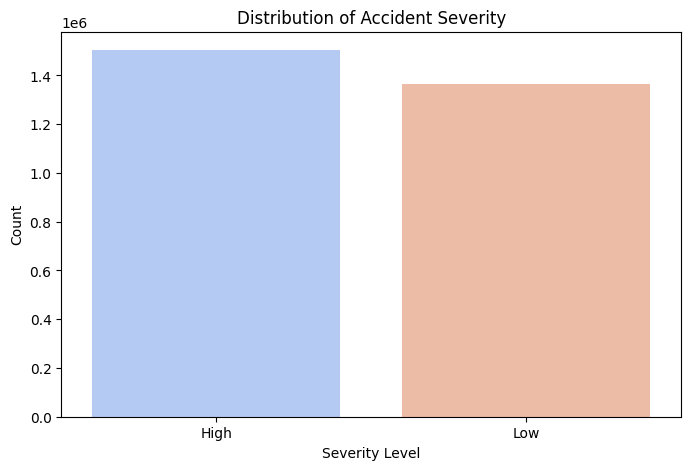

In [34]:
#Severity Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Severity_Binary', data=data, palette='coolwarm')
plt.title("Distribution of Accident Severity")
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.show()

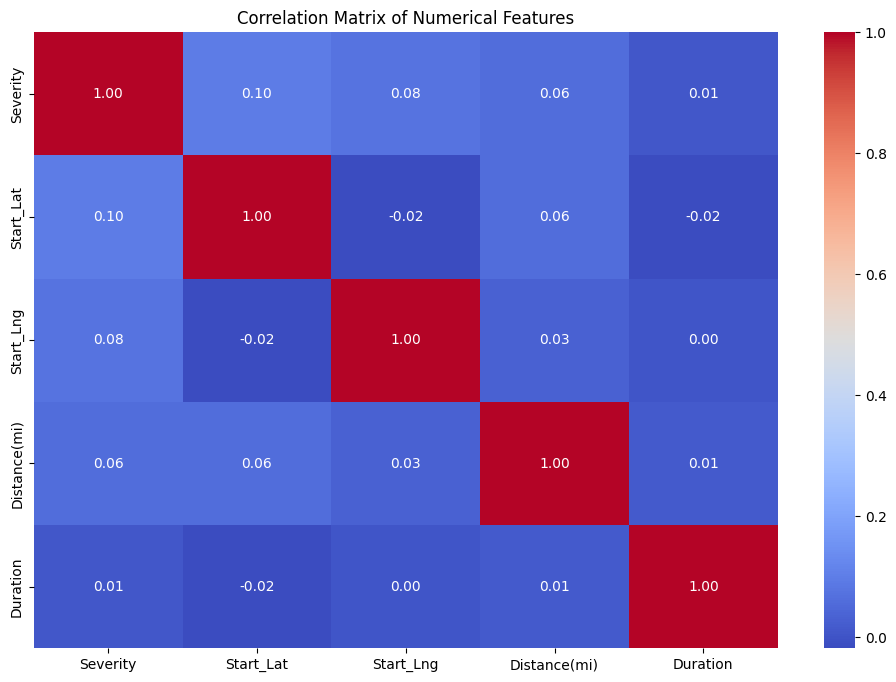

In [35]:
#Heatmap of Correlation (Numerical Features)
plt.figure(figsize=(12, 8))
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

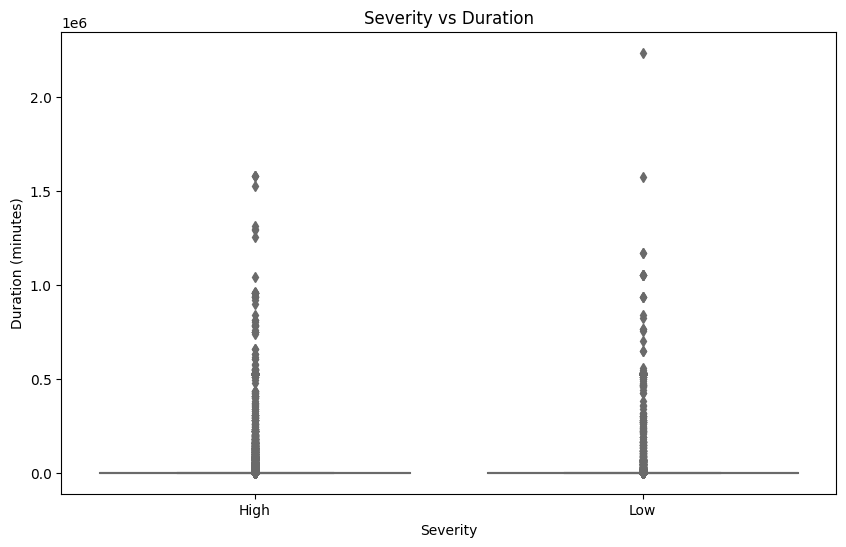

In [39]:
#Severity vs. Other Features
plt.figure(figsize=(10, 6))
sns.boxplot(x='Severity_Binary', y='Duration', data=data, palette='Set3')
plt.title("Severity vs Duration")
plt.xlabel("Severity")
plt.ylabel("Duration (minutes)")
plt.show()

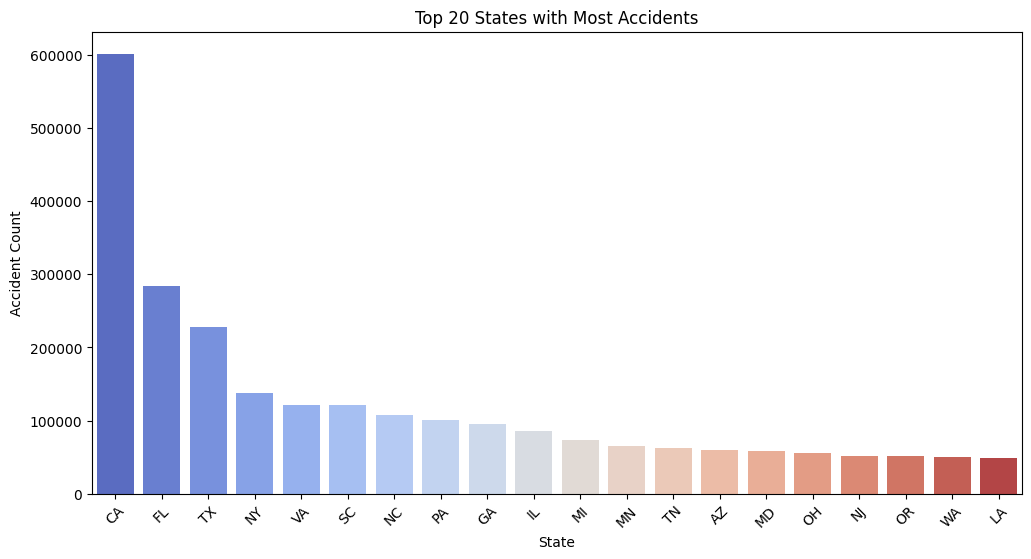

In [37]:
# Accidents by state
state_accidents = data['State'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=state_accidents.index[:20], y=state_accidents.values[:20], palette="coolwarm")
plt.title("Top 20 States with Most Accidents")
plt.xlabel("State")
plt.ylabel("Accident Count")
plt.xticks(rotation=45)
plt.show()


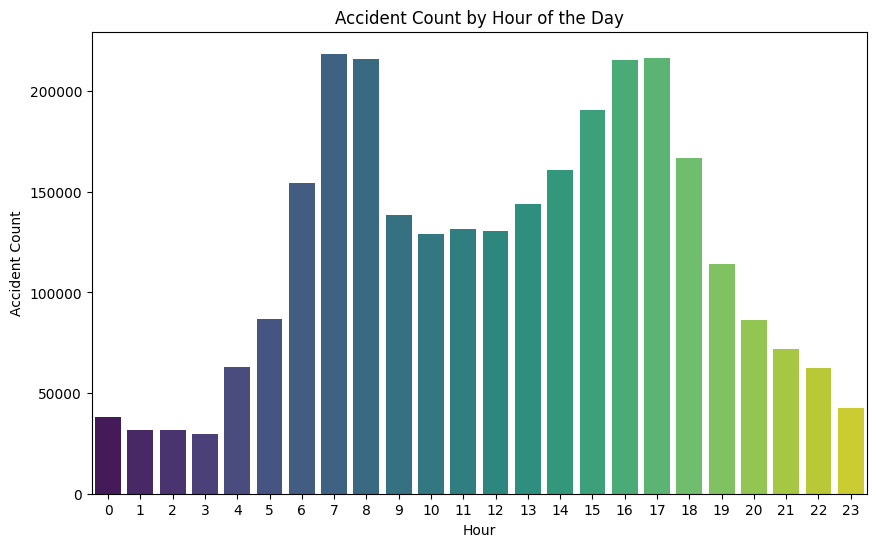

In [38]:
#Time-Based Analysis
data['Hour'] = data['Start_Time'].dt.hour
plt.figure(figsize=(10, 6))
sns.countplot(x='Hour', data=data, palette='viridis')
plt.title("Accident Count by Hour of the Day")
plt.xlabel("Hour")
plt.ylabel("Accident Count")
plt.xticks(range(0, 24))
plt.show()

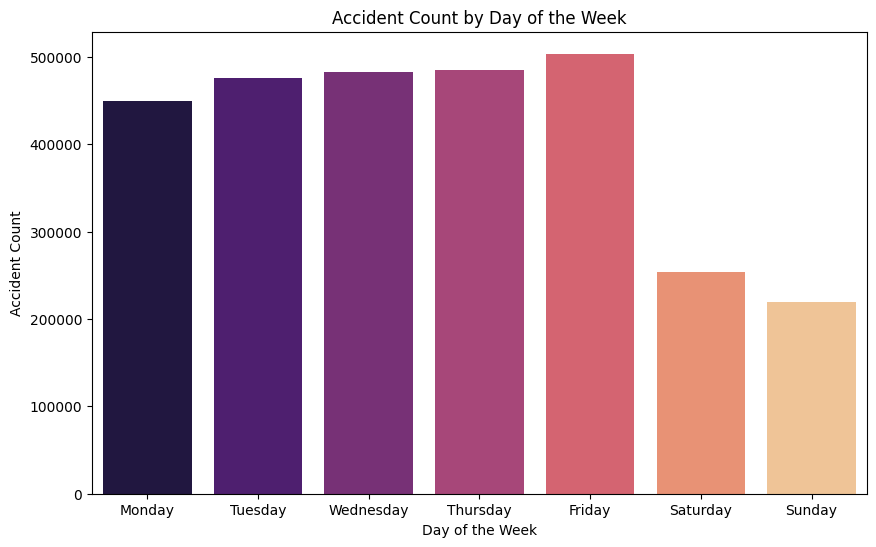

In [40]:
# Add day of the week
data['Day_of_Week'] = data['Start_Time'].dt.day_name()

# Accident count by day of the week
plt.figure(figsize=(10, 6))
sns.countplot(x='Day_of_Week', data=data, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='magma')
plt.title("Accident Count by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Accident Count")
plt.show()


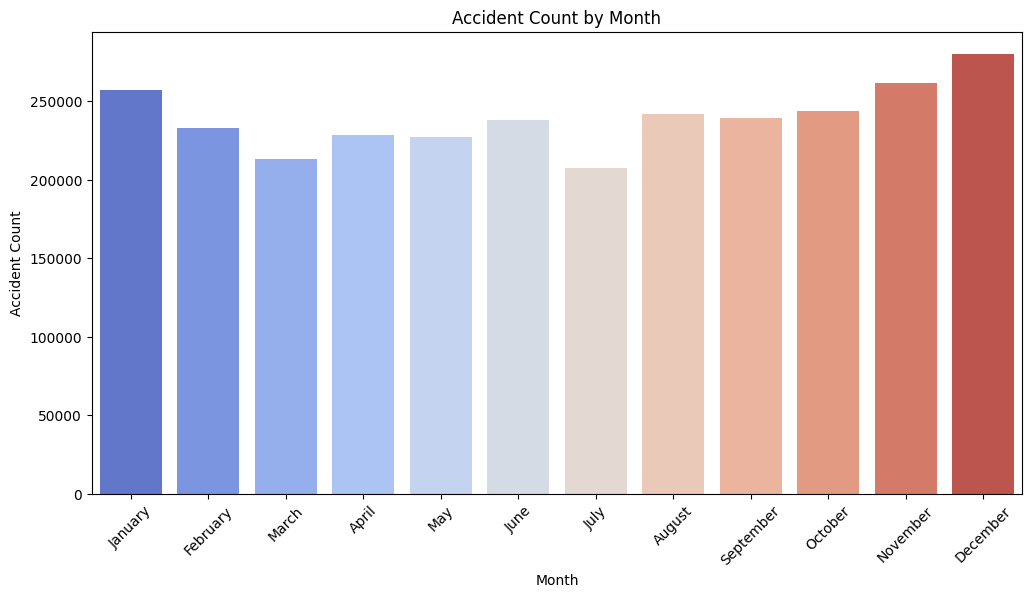

In [41]:
# Add month
data['Month'] = data['Start_Time'].dt.month_name()

# Accident count by month
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', data=data, order=pd.date_range("2023-01-01", periods=12, freq="M").strftime("%B"), palette='coolwarm')
plt.title("Accident Count by Month")
plt.xlabel("Month")
plt.ylabel("Accident Count")
plt.xticks(rotation=45)
plt.show()


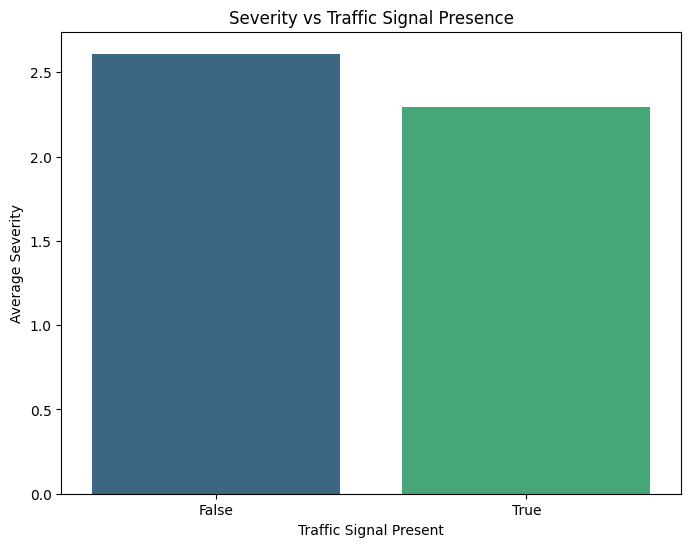

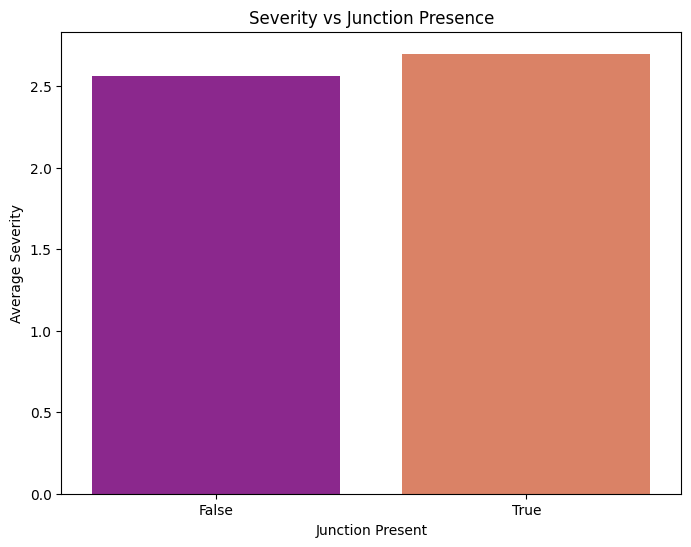

In [42]:
# Severity by Traffic Signal Presence
plt.figure(figsize=(8, 6))
sns.barplot(x='Traffic_Signal', y='Severity', data=data, ci=None, palette='viridis')
plt.title("Severity vs Traffic Signal Presence")
plt.xlabel("Traffic Signal Present")
plt.ylabel("Average Severity")
plt.show()

# Severity by Road Junction
plt.figure(figsize=(8, 6))
sns.barplot(x='Junction', y='Severity', data=data, ci=None, palette='plasma')
plt.title("Severity vs Junction Presence")
plt.xlabel("Junction Present")
plt.ylabel("Average Severity")
plt.show()


In [29]:
import folium
from folium.plugins import HeatMap

# Create a sample for plotting
sample_df = data.sample(10000)  

# Create a map centered at a mean location
center_lat = sample_df['Start_Lat'].mean()
center_lng = sample_df['Start_Lng'].mean()
map_accidents = folium.Map(location=[center_lat, center_lng], zoom_start=5)

# Add heat map
heat_data = list(zip(sample_df['Start_Lat'], sample_df['Start_Lng']))
HeatMap(heat_data).add_to(map_accidents)

map_accidents.save("Accident_Heatmap.html")
print("Heatmap saved as Accident_Heatmap.html")


Heatmap saved as Accident_Heatmap.html


# Preprocessing Data

In [43]:
def detect_outliers_iqr(df, columns):
    outlier_indices = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_indices[col] = outliers.index.tolist()
    return outlier_indices

num_cols = data.select_dtypes(include=['float64', 'int64']).columns
outliers = detect_outliers_iqr(data, num_cols)


for column, indices in outliers.items():
    print(f"Outliers in '{column}': {len(indices)} rows -> {indices if len(indices) < 10 else indices[:10]}...")

print("")

Outliers in 'Severity': 0 rows -> []...
Outliers in 'Start_Lat': 0 rows -> []...
Outliers in 'Start_Lng': 0 rows -> []...
Outliers in 'Distance(mi)': 427247 rows -> [0, 2, 6, 19, 52, 61, 65, 71, 75, 78]...
Outliers in 'Duration': 315246 rows -> [5, 9, 44, 48, 50, 60, 70, 79, 89, 92]...



In [44]:
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Apply capping to affected columns
columns_with_outliers = ['Distance(mi)', 'Duration']

for col in columns_with_outliers:
    data = cap_outliers(data, col)

In [45]:
data = data.drop(columns=['ID', 'Source', 'Start_Time', 'End_Time', 'Severity'], errors='ignore')

In [46]:
# Identify non-numeric columns
cat_cols = data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", cat_cols)


Non-numeric columns: Index(['Description', 'Street', 'City', 'County', 'State', 'Zipcode',
       'Country', 'Timezone', 'Airport_Code', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
       'Severity_Binary', 'Day_of_Week', 'Month'],
      dtype='object')


In [47]:
from sklearn.preprocessing import LabelEncoder

for col in cat_cols:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))


In [49]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


X = data.drop(['Severity_Binary'], axis=1)
y = data['Severity_Binary']


# Apply SMOTE on training data
#smote = SMOTE(random_state=42)
#X_smote, y_smote = smote.fit_resample(X, y)


print("Before SMOTE:", y.value_counts())
#print("After SMOTE:", y_smote.value_counts())

Before SMOTE: Severity_Binary
0    1504047
1    1366703
Name: count, dtype: int64


# Select Important Features 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

                  Feature  Importance
3             Description    0.289995
29               Duration    0.110215
4                  Street    0.103307
2            Distance(mi)    0.083168
1               Start_Lng    0.061922
0               Start_Lat    0.061412
8                 Zipcode    0.056843
30                   Hour    0.027805
6                  County    0.026021
5                    City    0.025359
11           Airport_Code    0.023163
23         Traffic_Signal    0.022395
32                  Month    0.022375
7                   State    0.021882
31            Day_of_Week    0.017299
14               Crossing    0.016165
10               Timezone    0.006819
21                   Stop    0.004753
16               Junction    0.004522
25         Sunrise_Sunset    0.003255
26         Civil_Twilight    0.002699
27      Nautical_Twilight    0.002469
28  Astronomical_Twilight    0.002393
20                Station    0.001624
12                Amenity    0.000876
18          

In [51]:
# Filter features based on importance threshold
important_features = feature_importances[feature_importances['Importance'] > 0.005]['Feature'].tolist()

# Select only important features
X_selected = X[important_features]

print("Selected Features:", X_selected.columns)

Selected Features: Index(['Description', 'Duration', 'Street', 'Distance(mi)', 'Start_Lng',
       'Start_Lat', 'Zipcode', 'Hour', 'County', 'City', 'Airport_Code',
       'Traffic_Signal', 'Month', 'State', 'Day_of_Week', 'Crossing',
       'Timezone'],
      dtype='object')


In [53]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42, stratify=y_temp)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 1722450
Validation set size: 688980
Test set size: 459320


# Build Model and Prediction

In [54]:
from sklearn.metrics import classification_report, confusion_matrix


rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)


y_val_pred = rf_model.predict(X_val)

print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93    360971
           1       0.93      0.90      0.92    328009

    accuracy                           0.92    688980
   macro avg       0.92      0.92      0.92    688980
weighted avg       0.92      0.92      0.92    688980



In [ ]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Grid Search for Random Forest
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)


best_rf_model = grid_search.best_estimator_

In [56]:
import random
random_indices = random.sample(range(len(X_test)), 10)

X_sample = X_test.iloc[random_indices]
y_sample = y_test.iloc[random_indices]

y_pred = rf_model.predict(X_sample)

results = pd.DataFrame({
    'Actual': y_sample,
    'Predicted': y_pred
})

print(results)

         Actual  Predicted
1634488       1          1
308489        1          1
1890872       0          0
2039817       0          0
477005        0          0
2394639       1          1
123871        0          0
975344        1          1
1749736       0          0
355737        0          0


In [57]:
import joblib

joblib.dump(rf_model, 'severity_model.joblib')

['severity_model.joblib']

In [ ]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np

model = joblib.load('severity_model.joblib')

# Initialize Flask app
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    
    df = pd.DataFrame(data)
    
    predictions = model.predict(df)

    # Map predictions to low impact (0) and high impact (1)
    severity_map = {1: 0, 2: 0, 3: 1, 4: 1}  # 1 & 2 -> low impact, 3 & 4 -> high impact
    predicted_impact = [severity_map[severity] for severity in predictions]
    return jsonify({
        'predictions': predicted_impact
    })

if __name__ == '__main__':
    app.run(debug=True)